In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

#from models.sub_cos_glm import Sub_Cos_GLM
#from models.sub_tcn import Sub_TCN
#from models.gru import GRU
#from models.lstm import LSTM
#from models.tcn import TCN
#from models.sub_cos_tcn import Sub_Cos_TCN
#from models.cos_tcn import Cos_TCN
from models.gru_exp import GRU

# Cosine Bases

In [2]:
cos_basis_no = 30
scale = 7.5
shift = 1
T_no = 500
        
kern_basis = torch.zeros(cos_basis_no, T_no)
for i in range(cos_basis_no):
    phi = 1.5707963267948966*i
    xmin = phi - 3.141592653589793
    xmax = phi + 3.141592653589793

    x_in = torch.arange(0, T_no, 1)
    raw_cos = scale  * torch.log(x_in + shift + 1e-7)

    basis = 0.5*torch.cos(raw_cos - phi) + 0.5
    basis[raw_cos < xmin] = 0.0
    basis[raw_cos > xmax] = 0.0
    kern_basis[i] = basis

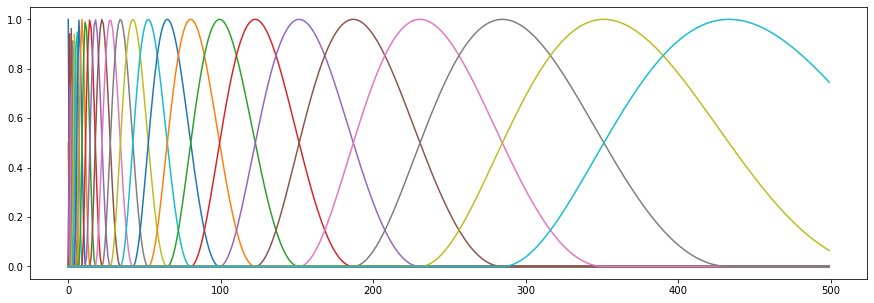

In [3]:
plt.figure(figsize = (15,5))
for i in range(cos_basis_no):
    plt.plot(kern_basis[i].cpu().detach().numpy())

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file  = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
V_file = "V_diff_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)

"""
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)
"""

C_syn_e = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub5_C_syn_e.npy")
C_syn_i = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub5_C_syn_i.npy")
C_syn_e = torch.from_numpy(C_syn_e).float()
C_syn_i = torch.from_numpy(C_syn_i).float()

#C_syn_e = C_syn_e[:,e_idx]
#C_syn_i = C_syn_i[:,i_idx]

In [3]:
T_train = 980 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 20
sub_no = 5
E_no = 2000
I_no = 200
#E_no = e_idx.shape[0]
#I_no = i_idx.shape[0]
T_no = 500
device = torch.device("cuda")

#layer_no = 3

increment = 50
batch_length = 50000
#batch_size = 5
batch_size = 4
iter_no = 9800*2
epoch_no = iter_no*batch_length*batch_size//T_train

# Preprocess

In [4]:
V_train = V[:T_train].float()
#V_test = V[-50000:].to(device).float()
V_test = V[50000*993:50000*994].to(device).float()

#test_E_neural = E_neural[-50000:].toarray()
#test_I_neural = I_neural[-50000:].toarray()
test_E_neural = E_neural[50000*993:50000*994].toarray()
test_I_neural = I_neural[50000*993:50000*994].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

# Train

In [5]:
#model = Sub_Cos_GLM(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
model = GRU(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = Sub_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
#model = LSTM(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, layer_no, device)
#model = Sub_Cos_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, layer_no, device)
#model = Cos_TCN(E_no, I_no, T_no, H_no, layer_no, device)

# GLM (1.025 for V_diff, 1 for noNA)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1.035**100))
#milestones = np.arange(increment-1, increment*100, increment)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1.035)

# GRU (1 for V_diff, 1 for noNA)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1**100))
milestones = np.arange(increment-1, increment*100, increment)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

21806


In [6]:
score_list = []

#for i in tnrange(iter_no):
for i in tnrange(10000):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, _ = model(batch_E_neural, batch_I_neural)
    #V_pred, _, _ = model(batch_E_neural[:,5000:35000,e_idx], batch_I_neural[:,5000:35000,i_idx])
    #V_pred = model(batch_E_neural, batch_I_neural)
    
    s = time.time()
    
    loss = torch.mean((V_pred- batch_V[:,:] )**2)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        #test_V_pred, test_sub_out, _ = model(test_E_neural.unsqueeze(0)[:,5000:35000,e_idx], test_I_neural.unsqueeze(0)[:,5000:35000,i_idx])
        #test_V_pred = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy()[:], test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[:]-test_V_pred)**2).item()
        score_list.append(test_score)
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-6-0878b7add691>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(10000):


  0%|          | 0/10000 [00:00<?, ?it/s]

0 0.013681 0.161866
49 0.075118 0.031875
99 0.271537 0.025095
149 0.285508 0.024666
199 0.305874 0.024
249 0.332988 0.023208
299 0.366242 0.022464
349 0.40459 0.020989
399 0.4525 0.01893
449 0.466312 0.018386
499 0.444442 0.019151
549 0.487799 0.017654
599 0.428433 0.019793
649 0.499407 0.017246
699 0.40888 0.020571
749 0.515558 0.016749
799 0.484245 0.017865
849 0.544751 0.015799
899 0.440827 0.019264
949 0.5364 0.016145
999 0.550659 0.015603
1049 0.522036 0.016488
1099 0.544608 0.015736
1149 0.518427 0.01659
1199 0.547141 0.015602
1249 0.541914 0.015792
1299 0.518728 0.016583
1349 0.499522 0.017302
1399 0.574611 0.014746
1449 0.529162 0.016242
1499 0.52109 0.016601
1549 0.573308 0.014904
1599 0.491892 0.017511
1649 0.496061 0.017735
1699 0.57623 0.014617
1749 0.597742 0.013869
1799 0.577865 0.014563
1849 0.557799 0.015325
1899 0.544954 0.015676
1949 0.571717 0.014865
1999 0.589054 0.014201
2049 0.505247 0.017046


KeyboardInterrupt: 

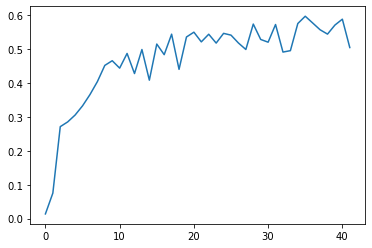

In [7]:
plt.plot(np.asarray(score_list))

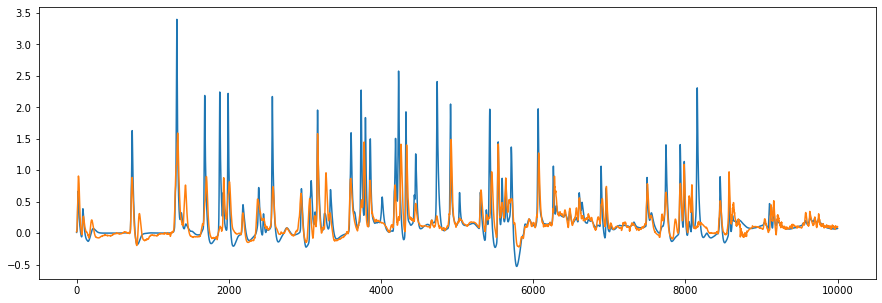

In [8]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[17000:27000])
plt.plot(test_V_pred.cpu().detach().numpy()[17000:27000])

In [9]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust8-30_noNA/global/glm_s1_h1.pt")